# Cell Capsule Analysis
This notebook analyses images of cell capsules to...
Images must be marked with a green ellipse to denote the cell wall.
This script then identifies the maximum distance between the cell wall and the cell capsule, and adds a second red ellipse.

The area between the red and green ellipses is then calculated in pixels, before being converted to microns using the scale bar contained in each image.
Further statistics are then calculated, such as the ratio of cell area to cell capsule area.

In [124]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

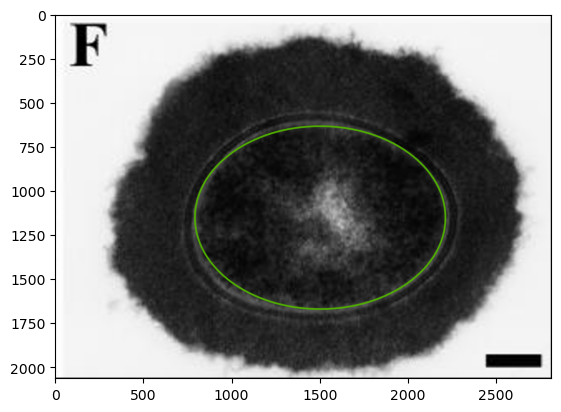

In [125]:
image_path = '/Users/Barney/Documents/Screenshots/AnnotatedSample.png'

# Read the image
image = cv2.imread(image_path)

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

imageOriginal = image.copy()

#  show the original image
plt.imshow(imageOriginal)

Analyse the image to find the green outline of the cell, and show the mask produced

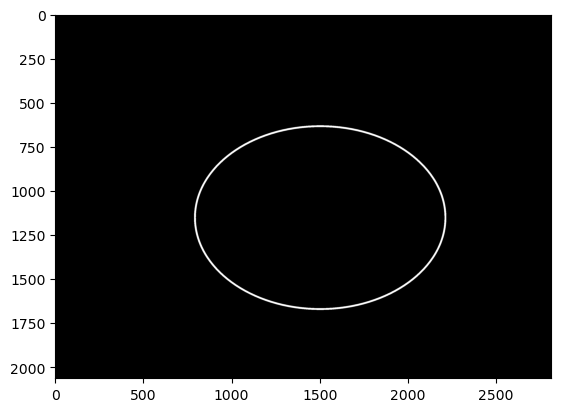

In [126]:
# Define range for green color in HSV
lower_green = (35, 50, 50)
upper_green = (85, 255, 255)

# Threshold the image to get only green
green_mask = cv2.inRange(hsv, lower_green, upper_green)

# call imshow() using plt object
plt.imshow(green_mask, cmap='gray')
  
# display that image
plt.show()

Now fit an ellipse to the masked image, so that the centre of the cell outline can be found.
Add a red cross to the image to mark the centre point.

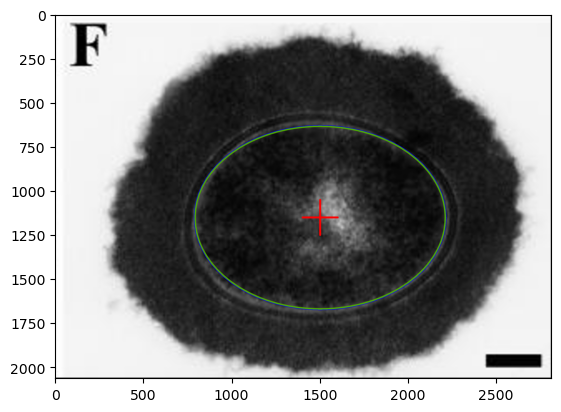

In [127]:
# Find contours
contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming the largest contour is our green outline, sort contours by area
contour = max(contours, key=cv2.contourArea)

# Fit an ellipse to the contour
ellipse = cv2.fitEllipse(contour)
(xc, yc), (d1, d2), angle = ellipse

# draw the fitted ellipse over the original image in red
imageEllipse = imageOriginal.copy()
cv2.ellipse(imageEllipse, ellipse, (0, 0, 255), 2)

# draw the center of the ellipse in red with a cross
cv2.line(imageEllipse, (int(xc) - 100, int(yc)), (int(xc) + 100, int(yc)), (255, 0, 0), 10)
cv2.line(imageEllipse, (int(xc), int(yc) - 100), (int(xc), int(yc) + 100), (255, 0, 0), 10)

# show the image
plt.imshow(imageEllipse)

With the cell centre and cell outline defined, start determining the maximum distance between the cell outline and the edge of the cell capsule.

Find the maximum distance between the cell wall and the cell capsule. Iterate through 360 degrees for the following steps:
1) Draw a blue line at 'x' degrees from the cell centre to the edge of the image.
2) create a mask using blue pixels produced by this line
3) combine this mask with a mask of white pixels in the image (cell capsule edge)
4) Of the remaining, non-zero pixels, calculate which is closest to the centre of the cell
5) calculate the distance between the closest non-zero pixel and the centre of the cell, and add to a list

The cell below illustrates this process for a single angle.

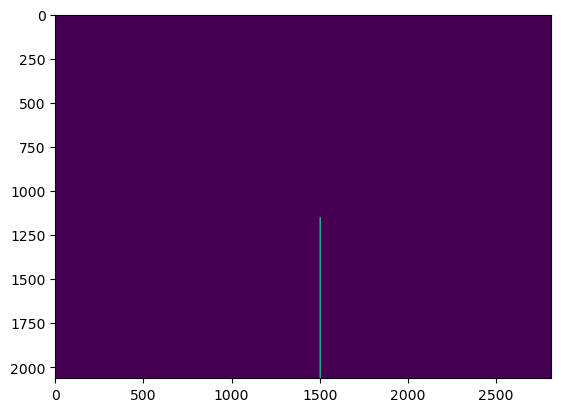

In [136]:
# angle  of the blue line
i = 90

# create a copy of the original image
imageExpandedOutline = imageOriginal.copy()

# find the width and height of the image
(h, w) = imageExpandedOutline.shape[:2]

# draw a line from the centre point to the edge of the ellipse in blue at the current angle
cv2.line(imageExpandedOutline, (int(xc), int(yc)), (int(xc + w * np.cos(i * np.pi / 180)), int(yc + h * np.sin(i * np.pi / 180))), (0, 0, 255), 4)

# Define range for blue color in HSV
lower_blue = (0,0,200)
upper_blue = (0,0,255)

# Threshold the HSV image to get only blue colors (this is repeated for each angle)
blue_mask = cv2.inRange(imageExpandedOutline, lower_blue, upper_blue)

# Define range for white in HSV
lower_white = (200,200,200)
upper_white = (255,255,255)

# Threshold the HSV image to get only white colors
white_mask = cv2.inRange(imageExpandedOutline, lower_white, upper_white)

# combine the blue and green masks to get the intersection of the new line with the outline of the green ellipse
combined_mask_1 = cv2.bitwise_and(green_mask, blue_mask)

 # combine the white and blue masks to get the intersection of the new line with the outline of the ellipse
combined_mask_2 = cv2.bitwise_and(blue_mask, white_mask)

# show the result of masking
combined_mask_3 = cv2.bitwise_or(combined_mask_1, combined_mask_2)

# show the result of masking
plt.imshow(blue_mask)

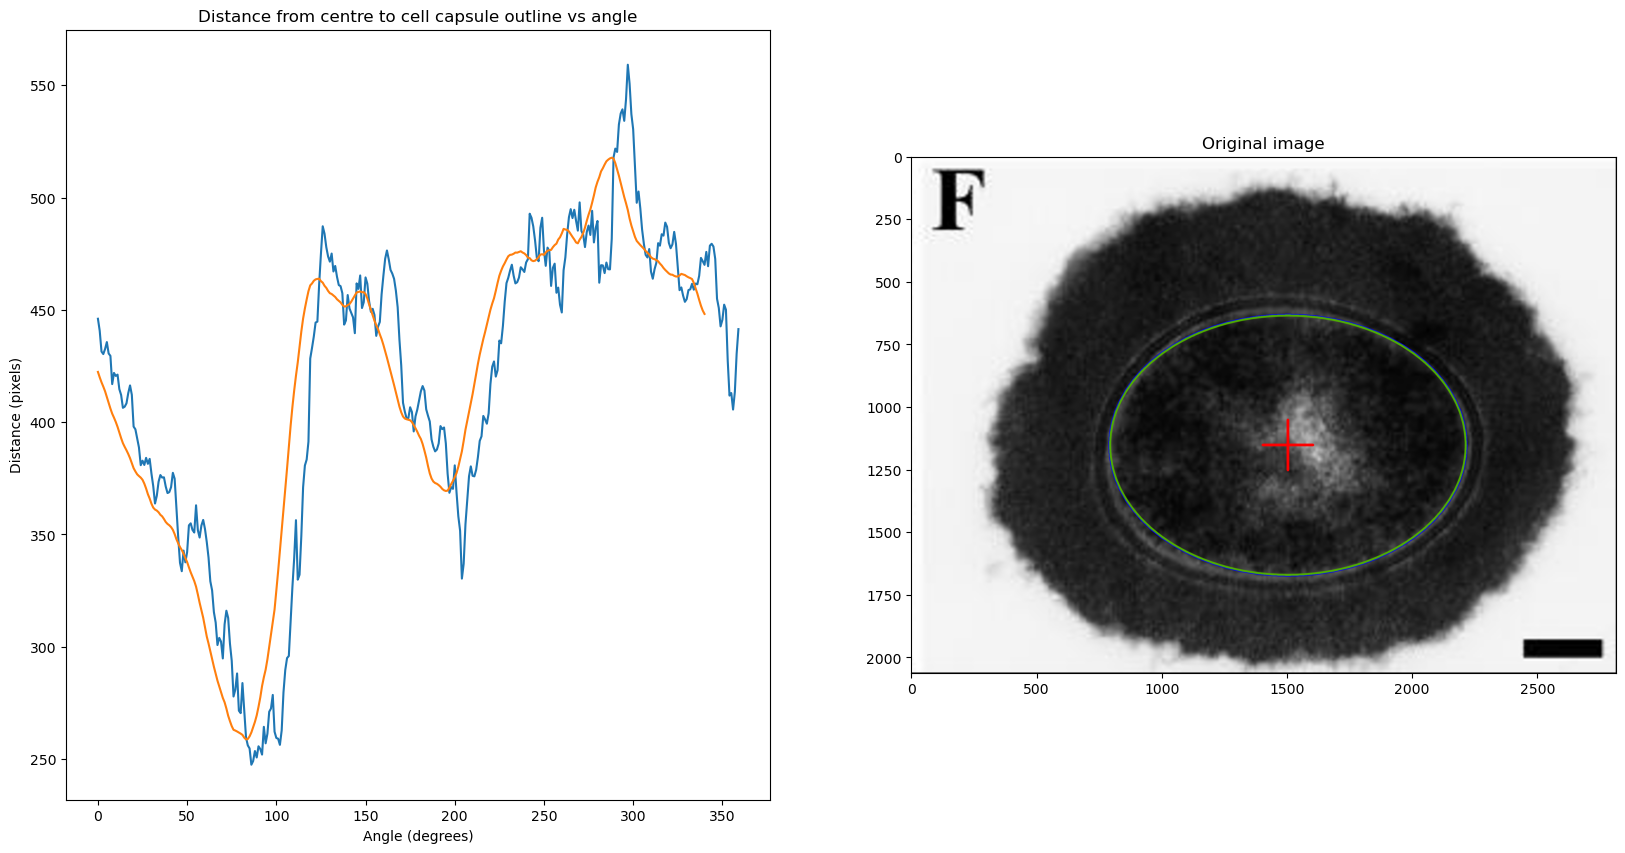

In [137]:
#  create a list of points on the outline of the new expanded ellipse
cellCapsuleOutlinePoints = []

imageExpandedOutline = imageOriginal.copy()

# Threshold the HSV image to get only white colors
white_mask = cv2.inRange(imageExpandedOutline, lower_white, upper_white)

# iterate through 360 degrees of rotation at 1 degree intervals
for i in range(0, 360, 1):
    # create a copy of the original image
    imageExpandedOutline = imageOriginal.copy()

    # find the width and height of the image
    (h, w) = imageExpandedOutline.shape[:2]

    # draw a line from the centre point to the edge of the ellipse in blue at the current angle
    cv2.line(imageExpandedOutline, (int(xc), int(yc)), (int(xc + w * np.cos(i * np.pi / 180)), int(yc + h * np.sin(i * np.pi / 180))), (0, 0, 255), 4)

    # Threshold the HSV image to get only white colors
    blue_mask = cv2.inRange(imageExpandedOutline, lower_blue, upper_blue)

    # combine the white and blue masks to get the intersection of the new line with the outline of the ellipse
    combined_mask = cv2.bitwise_and(blue_mask, white_mask)

    # find the co-ordinates non zero pixels in the combined mask
    nonZeroPixels = np.where(combined_mask == 255)

    #  find the distance from the centre of the ellipse to each of the non zero pixels
    distances = np.sqrt((nonZeroPixels[0] - xc) ** 2 + (nonZeroPixels[1] - yc) ** 2)

    # find the index of the closest point
    closest_index = np.argmin(distances)

    # add the shortest distance to the list of points defining the outline of the cell capsule
    centreToCapsuleOutlineDistance = distances[closest_index]

    # find the x and y co-ordinates of the closest point on the cell capsule to the cell centre (for plotting only)
    closest_x = nonZeroPixels[1][closest_index]
    closest_y = nonZeroPixels[0][closest_index]

    # combine the blue and green masks to get the intersection of the new line with the outline of the green ellipse
    combined_mask = cv2.bitwise_and(green_mask, blue_mask)

    # find the co-ordinates of the intersection
    intersect_x, intersect_y = np.where(combined_mask == 255)

    # find the distance between the centre of the ellipse and the intersection
    centreToCellOutlineDistance = np.sqrt((intersect_x[0] - xc) ** 2 + (intersect_y[0] - yc) ** 2)

    # add the distance to the list of distances between the cell outline and the cell capsule outline
    cellCapsuleOutlinePoints.append(centreToCapsuleOutlineDistance-centreToCellOutlineDistance)

# create a plot showing the distance from the centre to the cell capsule outline vs angle, with a second series showing the rolling average
# creat a second subplot showing the original image to the right of the first plot

cellCapsuleOutlinePointsFiltered = np.convolve(cellCapsuleOutlinePoints, np.ones(20), 'valid') / 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(cellCapsuleOutlinePoints)
ax1.plot(cellCapsuleOutlinePointsFiltered)
ax1.set_title('Distance from centre to cell capsule outline vs angle')
ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Distance (pixels)')
ax2.imshow(imageEllipse)
ax2.set_title('Original image')

plt.show()

# find the maximum distance from the centre to the cell capsule outline and the angle at which it occurs using the filtered data
maxDistance = max(cellCapsuleOutlinePointsFiltered)
maxDistanceIndex = np.argmax(cellCapsuleOutlinePointsFiltered)
maxDistanceAngle = maxDistanceIndex * 1


In [138]:
#  create a list of points on the outline of the new expanded ellipse
expandedOutlinePoints = []

# Define range for blue color in HSV
lower_blue = (0,0,200)
upper_blue = (0,0,255)

# iterate through 360 degrees of rotation at 1 degree intervals
for i in range(0, 360, 1):
    # create a copy of the original image
    imageExpandedOutline = imageOriginal.copy()

    # find the width and height of the image
    (h, w) = imageExpandedOutline.shape[:2]

    # draw a line from the centre point to the edge of the ellipse in red at the current angle
    cv2.line(imageExpandedOutline, (int(xc), int(yc)), (int(xc + w * np.cos(i * np.pi / 180)), int(yc + h * np.sin(i * np.pi / 180))), (0, 0, 255), 4)

    # Threshold the HSV image to get only blue colors
    blue_mask = cv2.inRange(imageExpandedOutline, lower_blue, upper_blue)

    # combine the blue and green masks to get the intersection
    combined_mask = cv2.bitwise_and(green_mask, blue_mask)

    # find the co-ordinates of the intersection
    intersect_x, intersect_y = np.where(combined_mask == 255)

    #  get the co-ordinates of the point 'x' pixels from the intersection at the current angle
    x = maxDistance

    # store the co-ordinates of the point 'x' pixels from the intersection at the current angle
    outlinePoint = int(intersect_y[0] + x * np.cos(i * np.pi / 180)), int(intersect_x[0] + x * np.sin(i * np.pi / 180))
    expandedOutlinePoints.append(outlinePoint)


use the expanded outline points to draw the new expanded outline of the ellipse

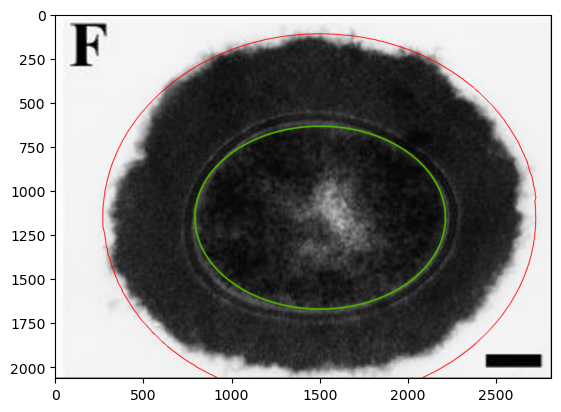

In [139]:
#  create a copy of the original image to draw the outline points on
imageExpandedOutline = imageOriginal.copy()

#  draw a line between each of the outline points in red by iterating through the list of points
for i in range(0, len(expandedOutlinePoints) - 1):
    cv2.line(imageExpandedOutline, expandedOutlinePoints[i], expandedOutlinePoints[i + 1], (255, 0, 0), 4)

#  draw a line between the first and last points in red
cv2.line(imageExpandedOutline, expandedOutlinePoints[0], expandedOutlinePoints[len(expandedOutlinePoints) - 1], (255, 0, 0), 4)

#  show the image
plt.imshow(imageExpandedOutline)

